# Import 

In [1]:
import itertools
import time

import matplotlib.pyplot as plt
import mlrose_hiive as mlrose
import numpy as np
import pandas as pd
import pathlib

from sklearn.random_projection import GaussianRandomProjection
from sklearn.cluster import MiniBatchKMeans
from matplotlib import offsetbox
from LoadData import LoadData
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA, TruncatedSVD, FastICA
from sklearn import mixture, random_projection

plt.style.use('ggplot')
dataset_name = "MNIST"

In [2]:
# Scale and visualize the embedding vectors
def plot_embedding(X, title=None, y=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
    if title is not None:
        plt.title(title)
    plt.tight_layout()

In [3]:
def runPCA(data, variance_coverage=0.95, title="Principal Components Analysis", dataset_name=None):
    print("Running Principal Components Analysis")
    pca = PCA(n_components=variance_coverage, svd_solver='full', random_state=0).fit(data)
    X_reduced = pca.transform(data)
    
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    
    axs[0].bar(range(X_reduced.shape[1]), pca.explained_variance_, alpha=0.5, align='center',label='individual variance')
    axs[0].set_title(title + "\nComponents={}\nVariance Explained=~{}%".format(X_reduced.shape[1], round(variance_coverage*100,2)))
    axs[0].legend()
    axs[0].set_ylabel('Variance ratio')
    axs[0].set_xlabel('Features')

    axs[1].scatter(list(range(X_reduced.shape[1])), pca.explained_variance_ratio_.cumsum())
    axs[1].plot(X_reduced.shape[1], variance_coverage, 'ko') 
    axs[1].annotate('[{}, {}]'.format(X_reduced.shape[1], variance_coverage*100), xy=(X_reduced.shape[1], variance_coverage), xytext=(X_reduced.shape[1]+4, variance_coverage+0.1), arrowprops=dict(facecolor='black', shrink=0.05))
    axs[1].plot(range(0, X_reduced.shape[1]), [variance_coverage for i in range(0, X_reduced.shape[1])] , "g--", alpha=0.5)
    axs[1].set_xlabel("N-Components")
    axs[1].set_ylabel("Variance Coverage")
    axs[1].plot([X_reduced.shape[1] for i in range(0, int(variance_coverage*100))], [i/100 for i in range(0, int(variance_coverage*100))] , "g--", alpha=0.5)
    axs[1].set_title(title + "\nComponents={}\nVariance Explained=~{}%".format(X_reduced.shape[1], round(variance_coverage*100,2)))
    fig.tight_layout()
    
    plt.savefig("Principal Component Cumulative Variable's Exlained Variance {}.png".format(dataset_name))

    return pca, X_reduced, X_reduced.shape[1]

In [4]:
def runICA(data, n_components=784, title="Independent Components Analysis"):
    print("Running Independent Components Analysis")
    temp_data = data.copy()
    transformer = FastICA(n_components=n_components,random_state=0, whiten=True).fit(temp_data)
    X_transformed = transformer.transform(temp_data)
    return transformer, X_transformed   

In [5]:
def runRandomizedProjections(data, dataset_name="", n_components=784, title="Random Projections"):
    print("Running Randomized Projections")
    temp_data = data.copy()
    transformer = GaussianRandomProjection(n_components=n_components).fit(temp_data)
    X_transformed = transformer.transform(temp_data)
    return transformer, X_transformed

In [6]:
def runRandomForest(data, labels, variance_coverage=0.95, title="Random Forest Regressor", dataset_name=None):
    print("Running Random Forest")
    temp_data = data.copy()
    model = RandomForestRegressor(random_state=1, max_depth=10)
    df = pd.DataFrame(temp_data)
    model.fit(df, labels)
    indices = np.argsort(model.feature_importances_)[::-1]
    result = np.cumsum(model.feature_importances_[indices])
    n_components = np.argmax(np.where(result < variance_coverage))
    X_reduced = temp_data[:, indices[:n_components]]

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    t = np.sort(model.feature_importances_)[::-1]
    axs[0].bar(range(X_reduced.shape[1]), np.sort(model.feature_importances_)[::-1][0:X_reduced.shape[1]], alpha=0.5, align='center',
               label='individual variance')
    axs[0].set_title(title + "\nComponents={}\nVariance Explained=~{}%".format(X_reduced.shape[1],
                                                                               round(variance_coverage * 100, 2)))
    axs[0].legend()
    axs[0].set_ylabel('Variance ratio')
    axs[0].set_xlabel('Features')

    axs[1].scatter(list(range(X_reduced.shape[1])), np.sort(model.feature_importances_)[::-1][0:X_reduced.shape[1]].cumsum())
    axs[1].plot(X_reduced.shape[1], variance_coverage, 'ko')
    axs[1].annotate('[{}, {}]'.format(X_reduced.shape[1], variance_coverage * 100),
                    xy=(X_reduced.shape[1], variance_coverage),
                    xytext=(X_reduced.shape[1] + 4, variance_coverage + 0.1),
                    arrowprops=dict(facecolor='black', shrink=0.05))
    axs[1].plot(range(0, X_reduced.shape[1]), [variance_coverage for i in range(0, X_reduced.shape[1])], "g--",
                alpha=0.5)
    axs[1].set_xlabel("N-Components")
    axs[1].set_ylabel("Variance Coverage")
    axs[1].plot([X_reduced.shape[1] for i in range(0, int(variance_coverage * 100))],
                [i / 100 for i in range(0, int(variance_coverage * 100))], "g--", alpha=0.5)
    axs[1].set_title(title + "\nComponents={}\nVariance Explained=~{}%".format(X_reduced.shape[1],
                                                                               round(variance_coverage * 100, 2)))
    fig.tight_layout()

    plt.savefig("Random_Forest_Variance_{}.png".format(dataset_name))

    return model, X_reduced, n_components

Attempting to load: mnist-train-data.csv

Loading Complete
Data Statistics: 
   Number of Entries: 5000 
   Shape of Entry: (785,)

Running Principal Components Analysis
Running Independent Components Analysis
Running Randomized Projections
Running Random Forest

Attempting to load: fashion-mnist-train-data.csv

Loading Complete
Data Statistics: 
   Number of Entries: 5000 
   Shape of Entry: (785,)

Running Principal Components Analysis
Running Independent Components Analysis
Running Randomized Projections
Running Random Forest



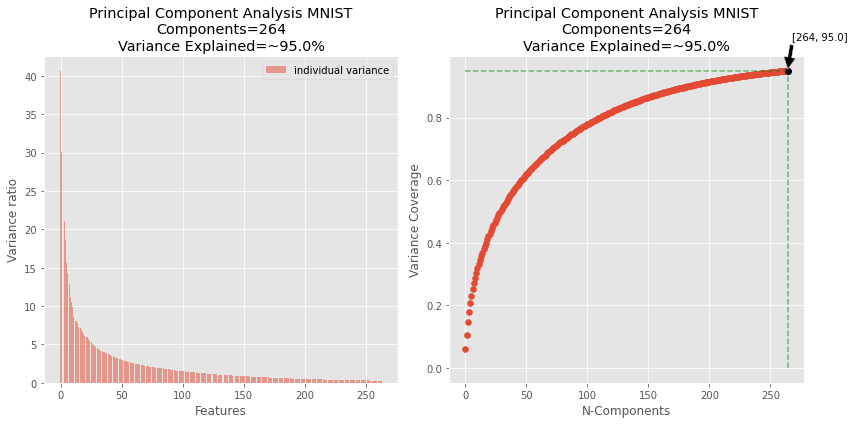

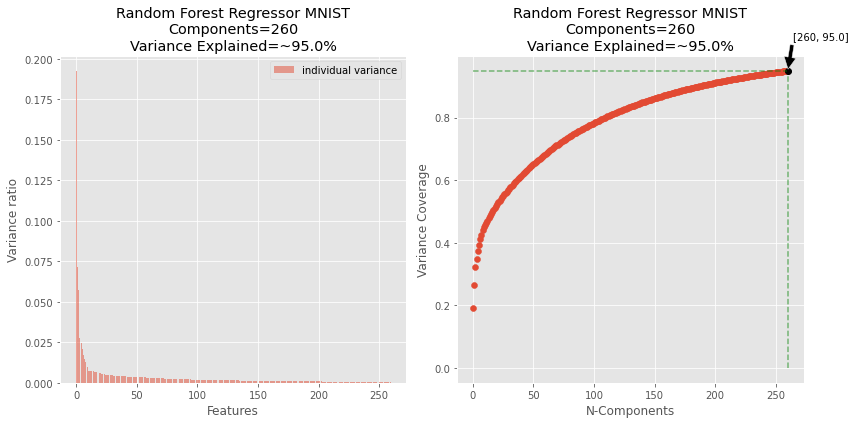

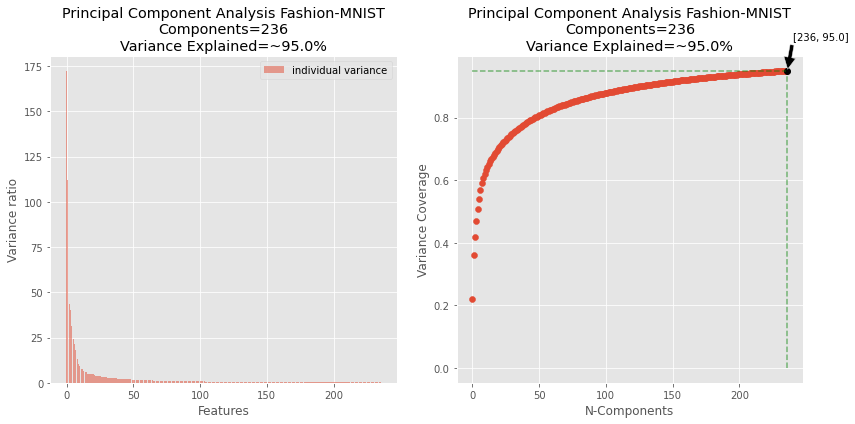

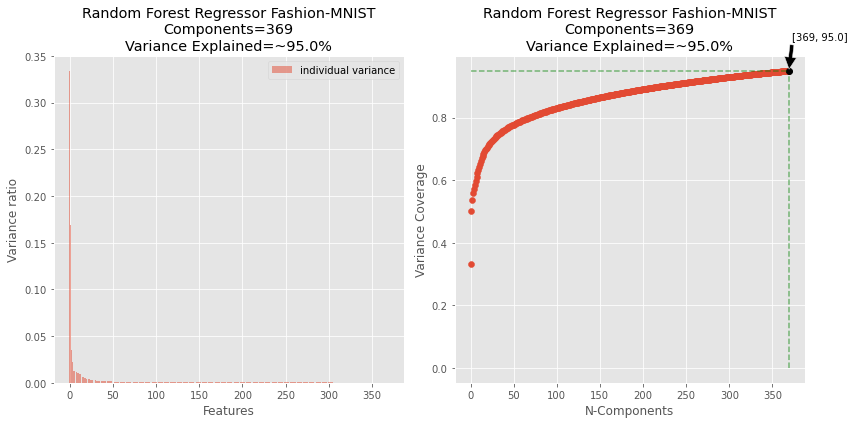

In [7]:
cwd = pathlib.Path().absolute()
for name in ["MNIST", "Fashion-MNIST"]:

    if name == "MNIST":
        training_data_path = "{}/mnist-train-data.csv".format(cwd)
    else:
        training_data_path = "{}/fashion-mnist-train-data.csv".format(cwd)
    # testing_data_path = "{}/medium-mnist-test-data.csv".format(cwd)

    training_labels, training_data, training_combined = LoadData(training_data_path, normalize=True, size=5000)

    PCA_Transformer, PCA_transformed_X, PCA_number_of_components = runPCA(training_data,
                                                                          variance_coverage=0.95,
                                                                          title="Principal Component Analysis {}".format(name),
                                                                          dataset_name=name)

    np.savetxt("PrincipalComponentReduced_{}.csv".format(name), PCA_transformed_X, delimiter=",", fmt="%.6e")
    np.savetxt("PrincipalComponentReduced_{}_Labels.csv".format(name), training_labels, delimiter=",", fmt="%.6e")

    ICA_transformer, ICA_transformed_X = runICA(training_data, n_components=784)
    np.savetxt("IndependentComponentReduced_{}.csv".format(name), ICA_transformed_X, delimiter=",", fmt="%.6e")
    np.savetxt("IndependentComponentReduced_{}_Labels.csv".format(name), training_labels, delimiter=",", fmt="%.6e")

    Random_Projection_Transformer, Random_Projection_transformed_X = runRandomizedProjections(training_data, title="Random Projection {}".format(dataset_name), dataset_name=name)
    np.savetxt("RandomProjectionReduced_{}.csv".format(name), Random_Projection_transformed_X, delimiter=",", fmt="%.6e")
    np.savetxt("RandomProjectionReduced_{}_Labels.csv".format(name), training_labels, delimiter=",", fmt="%.6e")

    Random_Forest_Transformer, Random_Forest_transformed_X, Random_Forest_Number_Components = runRandomForest(training_data, training_labels, title="Random Forest Regressor {}".format(name), dataset_name=name)
    
    np.savetxt("RandomForestReduced_{}.csv".format(name), Random_Forest_transformed_X, delimiter=",", fmt="%.6e")
    np.savetxt("RandomForestReduced_{}_Labels.csv".format(name), training_labels, delimiter=",", fmt="%.6e")

    print()